In [1]:
import numpy as np
import random
import copy
import math
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def eliminacao_gauss(A, b, max_iter=5):
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)
    n = A.shape[0]

    for i in range(n - 1):
        max_row = np.argmax(np.abs(A[i:, i])) + i
        if A[max_row, i] == 0:
            raise np.linalg.LinAlgError(f"Matriz singular na coluna {i}")
        if max_row != i:
            A[[i, max_row]] = A[[max_row, i]]
            b[[i, max_row]] = b[[max_row, i]]
        L = A[i+1:, i] / A[i, i]
        A[i+1:, i:] -= np.outer(L, A[i, i:])
        b[i+1:]    -= L * b[i]
    x = np.zeros(n, dtype=float)
    for i in range(n-1, -1, -1):
        x[i] = (b[i] - A[i, i+1:] @ x[i+1:]) / A[i, i]

    for _ in range(max_iter):
        r = b - A @ x
        delta = np.zeros(n, dtype=float)
        for i in range(n-1, -1, -1):
            delta[i] = (r[i] - A[i, i+1:] @ delta[i+1:]) / A[i, i]
        x += delta

    return x

In [3]:
class Individual:
    def __init__(self, initial_positions: List[List[float]], min_matrix: List[List[float]], 
                 max_matrix: List[List[float]], b_vector: List[float]):
        self.initial_positions = initial_positions
        self.min_matrix = min_matrix
        self.max_matrix = max_matrix
        self.b_vector = b_vector
        self.n = len(initial_positions)
        self.graph = self._initialize_graph()
    
    def _initialize_graph(self) -> List[List[float]]:
        graph = [[0.0] * self.n for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                if self.max_matrix[i][j] > 0:
                    val = self.initial_positions[i][j] * random.uniform(
                        self.min_matrix[i][j], self.max_matrix[i][j])
                    graph[i][j] = val
                    graph[j][i] = val
        return graph

    def fitness(self, tester: List[List[float]]) -> float:
        n = len(self.initial_positions)
        pontuacoes = []
    
        for _ in range(10):
            A = [[0.0] * n for _ in range(n)]
            for i in range(n):
                for j in range(n):
                    A[i][j] = self.initial_positions[i][j] * tester[i][j]
    
            try:
                solution = eliminacao_gauss(A, self.b_vector.copy(), 5)
    
                total_abs = sum(abs(x) for x in solution)
                if total_abs == 0:
                    pontuacoes.append(0.0)
                else:
                    pontuacoes.append(10.0 * n / total_abs)
            except ValueError:
                pontuacoes.append(0.0)
    
        return sum(pontuacoes) / len(pontuacoes)

    def mutate(self, mutation_rate: float) -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < MU_TAX:
                    new_positions[i][j] = 1 - new_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def randomize(self) -> 'Individual':
        new_positions = [[1 if i==j else 0 for j in range(self.n)] for i in range(self.n)]
        for i in range(self.n):
            for j in range(i+1, self.n):
                if random.random() < 0.5:
                    new_positions[i][j] = 1
                    new_positions[j][i] = 1
                else:
                    new_positions[i][j] = 0
                    new_positions[j][i] = 0
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def cross(self, other: 'Individual') -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < 0.5:
                    new_positions[i][j] = other.initial_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def copy(self) -> 'Individual':
        return Individual(
            copy.deepcopy(self.initial_positions), 
            self.min_matrix,
            self.max_matrix,
            copy.deepcopy(self.b_vector)
        )

    def get_graph(self) -> List[List[float]]:
        return self.graph

    def get_b(self) -> List[float]:
        return self.b_vector

    def __str__(self) -> str:
        return f"Individual:\n{self.initial_positions}"

In [4]:
def generate_tester(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                    max_matrix: List[List[float]]) -> List[List[float]]:
    n = len(initial_positions)
    tester = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if max_matrix[i][j] > 0:
                val = random.uniform(min_matrix[i][j], max_matrix[i][j])
                tester[i][j] = val
                tester[j][i] = val
    return tester

In [5]:
def select_parent_torneio(population: List[Individual], fitness: List[float], 
                          tournament_size: int) -> List[Individual]:
    selected = []
    for _ in range(2):
        tournament = random.sample(list(zip(population, fitness)), tournament_size)
        best = max(tournament, key=lambda x: x[1])[0]
        selected.append(best)
    return selected

In [6]:
def run_ag(initial_positions: List[List[float]], min_matrix: List[List[float]], 
           max_matrix: List[List[float]], b_vector: List[float]) -> Individual:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    population = [template.copy()]
    for _ in range(1, POP_SIZE):
        population.append(template.randomize())
    
    best_individual = None
    best_fitness = float('-inf')
    history = []
    
    for gen in range(GEN):
        fitness_list = [ind.fitness(tester) for ind in population]
        
        current_best_idx = np.argmax(fitness_list)
        current_best = population[current_best_idx]
        current_fitness = fitness_list[current_best_idx]
        
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_individual = current_best.copy()
        
        history.append(current_fitness)
        
        new_population = []
        while len(new_population) < POP_SIZE:
            parents = select_parent_torneio(population, fitness_list, 5)
            child = parents[0].cross(parents[1])
            child = child.mutate(MU_TAX)
            new_population.append(child)
        
        population = new_population
    
    return best_individual, history

In [7]:
def best_realocate(initial_positions, min_matrix, max_matrix, b):
    return run_ag(initial_positions, min_matrix, max_matrix, b)

In [8]:
def run_ag_island(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                  max_matrix: List[List[float]], b_vector: List[float], 
                  num_islands: int, migration_interval: int, migration_size: int
                 ) -> Tuple[Individual, List[List[float]]]:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    history = [[] for _ in range(num_islands)]
    islands = []

    for _ in range(num_islands):
        pop = [template.copy()]
        for _ in range(1, POP_SIZE):
            pop.append(template.randomize())
        islands.append(pop)

    best_global = None
    best_global_fitness = float('-inf')

    for gen in range(GEN):
        for island_idx in range(num_islands):
            pop = islands[island_idx]
            fitness_list = [ind.fitness(tester) for ind in pop]

            current_best_idx = np.argmax(fitness_list)
            current_best = pop[current_best_idx]
            current_fitness = fitness_list[current_best_idx]

            if current_fitness > best_global_fitness:
                best_global_fitness = current_fitness
                best_global = current_best.copy()

            history[island_idx].append(current_fitness)

            new_pop = []
            while len(new_pop) < POP_SIZE:
                parents = select_parent_torneio(pop, fitness_list, 5)
                child = parents[0].cross(parents[1])
                child = child.mutate(MU_TAX)
                new_pop.append(child)

            islands[island_idx] = new_pop

        if gen % migration_interval == 0 and gen != 0 and num_islands > 1:
            migrants = []
            for island in islands:
                island.sort(key=lambda ind: ind.fitness(tester), reverse=True)
                migrants.append(island[:migration_size])
            
            for i in range(num_islands):
                next_idx = (i + 1) % num_islands
                islands[next_idx].sort(key=lambda ind: ind.fitness(tester))
                for j in range(migration_size):
                    islands[next_idx][j] = migrants[i][j].copy()

    return best_global, history

In [9]:
def best_realocate_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size):
    return run_ag_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size)

In [10]:
POP_SIZE = 20
GEN = 500
MU_TAX = 0.02

NUM_ISLAND = 3
MIGRATION_INT = 20
MIGRATION_SIZE = 2

initial_positions = [
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1]
]
min_matrix = [
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]
max_matrix = [
    [100, 80, 0, 0, 0],
    [80, 100, 80, 0, 0],
    [0, 80, 100, 80, 0],
    [0, 0, 80, 100, 80],
    [0, 0, 0, 80, 100]
]
b = [200, 75, 175, 90, 100]

print("Inicial:", Individual(initial_positions, min_matrix, max_matrix, b))

Inicial: Individual:
[[1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 1, 1], [0, 0, 0, 1, 1]]


In [11]:
n = len(initial_positions)
tester = [[0.0] * n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if initial_positions[i][j] != 0:
            val = initial_positions[i][j] * random.random() * (max_matrix[i][j] - min_matrix[i][j])
            tester[i][j] = val
            tester[j][i] = val

In [12]:
try:
    A = np.array(tester)
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)

ind_initial = Individual(initial_positions, min_matrix, max_matrix, b)
print("Fitness:", ind_initial.fitness(tester))

best, history_simple = best_realocate(initial_positions, min_matrix, max_matrix, b)
print("Melhor indivíduo encontrado:", best)

Solução:
== 3.9520966118336656
== -0.7992297352358062
== 1.3566010669104667
== 2.065307903570423
== 1.4044893896598845
Fitness: 5.220446559960039
Melhor indivíduo encontrado: Individual:
[[1, 1, 1, 0, 0], [1, 1, 1, 0, 1], [1, 1, 1, 0, 0], [0, 0, 0, 1, 1], [0, 1, 0, 1, 1]]


In [13]:
best_island, history_island = best_realocate_island(
    initial_positions,
    min_matrix,
    max_matrix,
    b,
    NUM_ISLAND,
    MIGRATION_INT,
    MIGRATION_SIZE,
)
try:
    A = np.array(best_island._initialize_graph())
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)
print("Fitness:", best_island.fitness(tester))
print("Melhor indivíduo com estratégia de ilhas:")
print(best_island)

Solução:
== -6.057043760431862
== 4.990186003137663
== 0.18071330511922165
== 2.288098286487457
== 1.0917115514990612
Fitness: 5.13865128763458
Melhor indivíduo com estratégia de ilhas:
Individual:
[[1, 1, 0, 0, 0], [1, 1, 1, 0, 1], [0, 1, 1, 1, 1], [0, 0, 1, 1, 0], [0, 1, 1, 0, 1]]


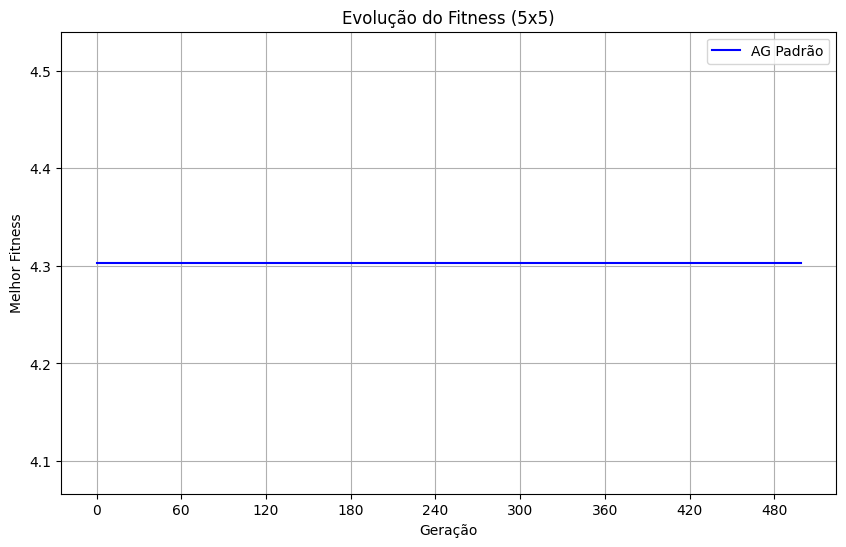

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(history_simple)), 
    history_simple, 
    'b-', 
    label='AG Padrão'
)
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.show()

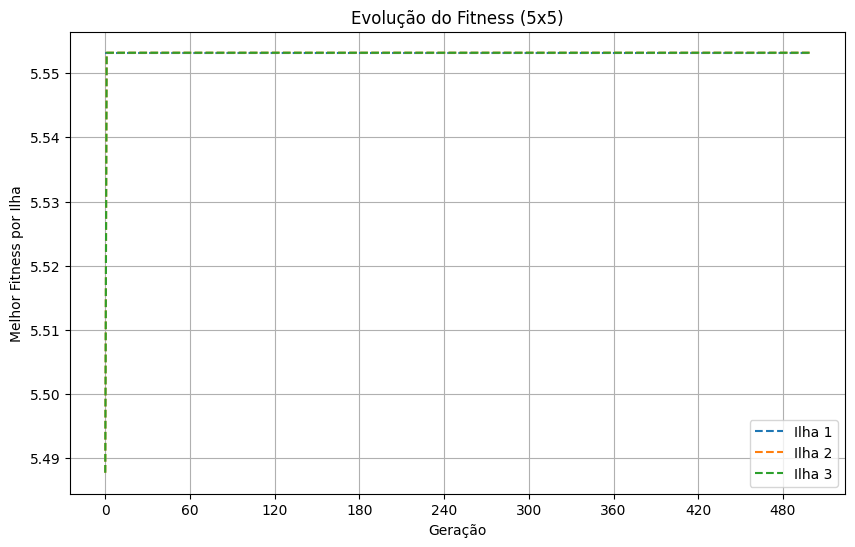

In [15]:
plt.figure(figsize=(10, 6))
for idx, history in enumerate(history_island):
    plt.plot(
        range(len(history)),
        history,
        linestyle='--',
        label=f'Ilha {idx + 1}'
    )
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness por Ilha')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness.png', dpi=300)
plt.show()